# Предобработка данных поездок и погодных условий

В этой тетрадке выполняется полный процесс подготовки данных о поездках и погоде перед дальнейшим анализом и построением моделей. Основная цель — получить **чистый, непротиворечивый и готовый к анализу набор данных**, учитывающий как характеристики поездок, так и погодные условия.

Обрабатываемые данные включают:
- Информацию о поездках: маршруты, время, стоимость, длительность и т.п.
- Погодные показатели: температура, осадки, ветер, облачность, солнечная инсоляция.

Процесс подготовки данных включает следующие ключевые этапы:

### 1. Импорт библиотек и загрузка данных
   Загрузка исходных CSV-файлов, проверка структуры данных и базовые операции по чтению.

### 2. Переименование колонок
   Приведение названий столбцов к единому формату `snake_case` для удобства дальнейшей обработки.

### 3. Очистка данных о поездках
   - Удаление дубликатов
   - Нормализация адресов и районов
   - Обработка пропусков (восстановление значений медианой по маршрутам)
   - Удаление экстремальных значений методом IQR
   - Создание новых признаков
   - Преобразование типов и категоризация признаков

### 4. Очистка данных о погоде
   - Удаление лишних столбцов и служебных строк
   - Преобразование типов данных
   - Создание признаков месяца и часа
   - Заполнение пропусков с учётом цикличности (месяц/час) и интерполяции

### 5. Сохранение итоговых файлов
   Формирование полностью очищенных датасетов, готовых к дальнейшему анализу и моделированию.

## 1. Импорт библиотек

In [1]:
import pandas as pd

try:
    from utils.cleaning import (
    normalize_street, normalize_district, normalize_day_of_week,
    drop_outlers, fill_na_median_by_group, interpolate_time
)
    from utils.features import get_total_price
    from utils.vizualization import plot_hist_boxplot
    from utils.paths import join_path as pj
except ImportError:
    from scooter_sharing_analysis.utils.cleaning import (
    normalize_street, normalize_district, normalize_day_of_week,
    drop_outlers, fill_na_median_by_group, interpolate_time
)
    from scooter_sharing_analysis.utils.features import get_total_price
    from scooter_sharing_analysis.utils.vizualization import plot_hist_boxplot
    from scooter_sharing_analysis.utils.paths import join_path as pj


## 2. Чтение и подготовка данных

Задаём пути к файлам, параметры чтения CSV и загружаем данные с проверкой ошибок.

In [2]:
# Настраиваем словари с параметрами чтения CSV: путь, кодировка, дата-колонки
rides_options = {
    "filepath_or_buffer": pj("data", "rides.csv"),
    "encoding": "utf-8",
    "parse_dates": ["Start Date", "End Date"],
}

weather_options = {
    "filepath_or_buffer": pj("data", "weather.csv"),
    "encoding": "utf-8",
    "parse_dates": ["Datetime"]
}

try:
    rides_data = pd.read_csv(**rides_options)
    weather_data = pd.read_csv(**weather_options)
except pd.errors.ParserError as e:
    print(f"Error: {e}")
    rides_data = pd.read_csv(**rides_options, sep=";")
    weather_data = pd.read_csv(**weather_options, sep=";")

## 3. Переименование колонок

Приводим названия колонок к snake_case для удобства работы.

In [3]:
rides_data.rename(lambda col: col.strip().lower().replace(" ", "_"), axis="columns", inplace=True)

weather_data.rename(lambda col: col.strip().lower().replace(" ", "_"), axis="columns", inplace=True)

## 4. Очистка данных о поездках

### 4.1. Удаление дубликатов

In [4]:
rides_data = rides_data.drop_duplicates()

rides_data.duplicated().sum()

np.int64(0)

Удаляем неявные дубликаты, повторяющиеся по id и времени старта.

### 4.2. Нормализация адресов и районов

Применяем функции из модуля `cleaning` для стандартизации названий улиц и районов.

In [5]:
rides_data["start_location"] = rides_data["start_location"].apply(normalize_street)
rides_data["end_location"] = rides_data["end_location"].apply(normalize_street)

In [6]:
rides_data["start_district"] = rides_data["start_district"].apply(normalize_district)
rides_data["end_district"] = rides_data["end_district"].apply(normalize_district)

### 4.3. Удаление пропусков
На этапе первичного анализа было выявлено, что пропусков в данных крайне мало (менее 1%). Для пропусков в колонке distance сначала применяется заполнение медианным значением для соответствующего маршрута (start_location → end_location). Это позволяет восстановить расстояние поездки на основе аналогичных маршрутов.

После заполнения оставшиеся пропуски (например, в других колонках) можно безопасно удалить, так как их доля крайне мала и это не повлияет на общую структуру данных.


In [7]:
# Заполняем пропуски в distance медианой по маршруту
rides_data = fill_na_median_by_group(rides_data, ["distance"], ["start_location", "end_location"])

# Удаляем оставшиеся строки с пропусками
rides_data.dropna(inplace=True)

# Проверка, что пропусков больше нет
rides_data.isnull().sum()

id                0
start_date        0
end_date          0
start_location    0
start_district    0
end_location      0
end_district      0
distance          0
promo             0
dtype: int64

### 4.4. Удаление экстремальных значением

Применяем метод межквартильного размаха (IQR) для очистки датасета от экстремальных значений в колонке `distance`.

In [8]:
rides_data = drop_outlers(rides_data, "distance", k=3)
rides_data = rides_data[rides_data["distance"] >= 200]

### 4.5. Создание новых признаков

Добавляем день недели и перемещаем колонку на удобную позицию.

In [9]:
rides_data["day_of_week"] = rides_data["start_date"].dt.dayofweek

col = rides_data.pop('day_of_week')
rides_data.insert(3, 'day_of_week', col)

Добавляем итоговое время поездки.

In [10]:
td = rides_data["end_date"] - rides_data["start_date"]

rides_data["duration_minutes"] = (td.dt.total_seconds() / 60).round()

Добавляем итоговую стоимость поездки.

In [11]:
rides_data["total_price"] = rides_data.apply(get_total_price, axis=1)

Добавляем признак скорости поездки (`km/ч`):

In [12]:
rides_data["speed_km_per_h"] = (rides_data["distance"] / 1000) / (rides_data["duration_minutes"] / 60)

Создаем временной признак: начало поездки, округлённое до часа (для последующего объединения с погодой)

In [13]:
rides_data['hour_timestamp'] = rides_data['start_date'].dt.floor('h')

Создаем временной признак: начало поездки, округлённое до часа (для последующего анализа корреляций)

In [14]:
rides_data['day_timestamp'] = rides_data['start_date'].dt.floor('D')

### 4.6 Оценка адекватность новых факторов

Рассмотрим распределения созданных признаков:

In [15]:
new_factors = ["duration_minutes", "total_price", "speed_km_per_h"]

In [16]:
rides_data[new_factors].describe().T

,count,mean,std,min,25%,50%,75%,max
duration_minutes,93286.0,26.371031,9.954598,3.00000,19.000000,25.0000,31.000000,85.000000
total_price,93286.0,178.542407,65.778950,20.00000,132.000000,168.0000,210.000000,625.000000
speed_km_per_h,93286.0,9.198018,2.069503,2.28973,7.797418,9.1824,10.566289,29.322857


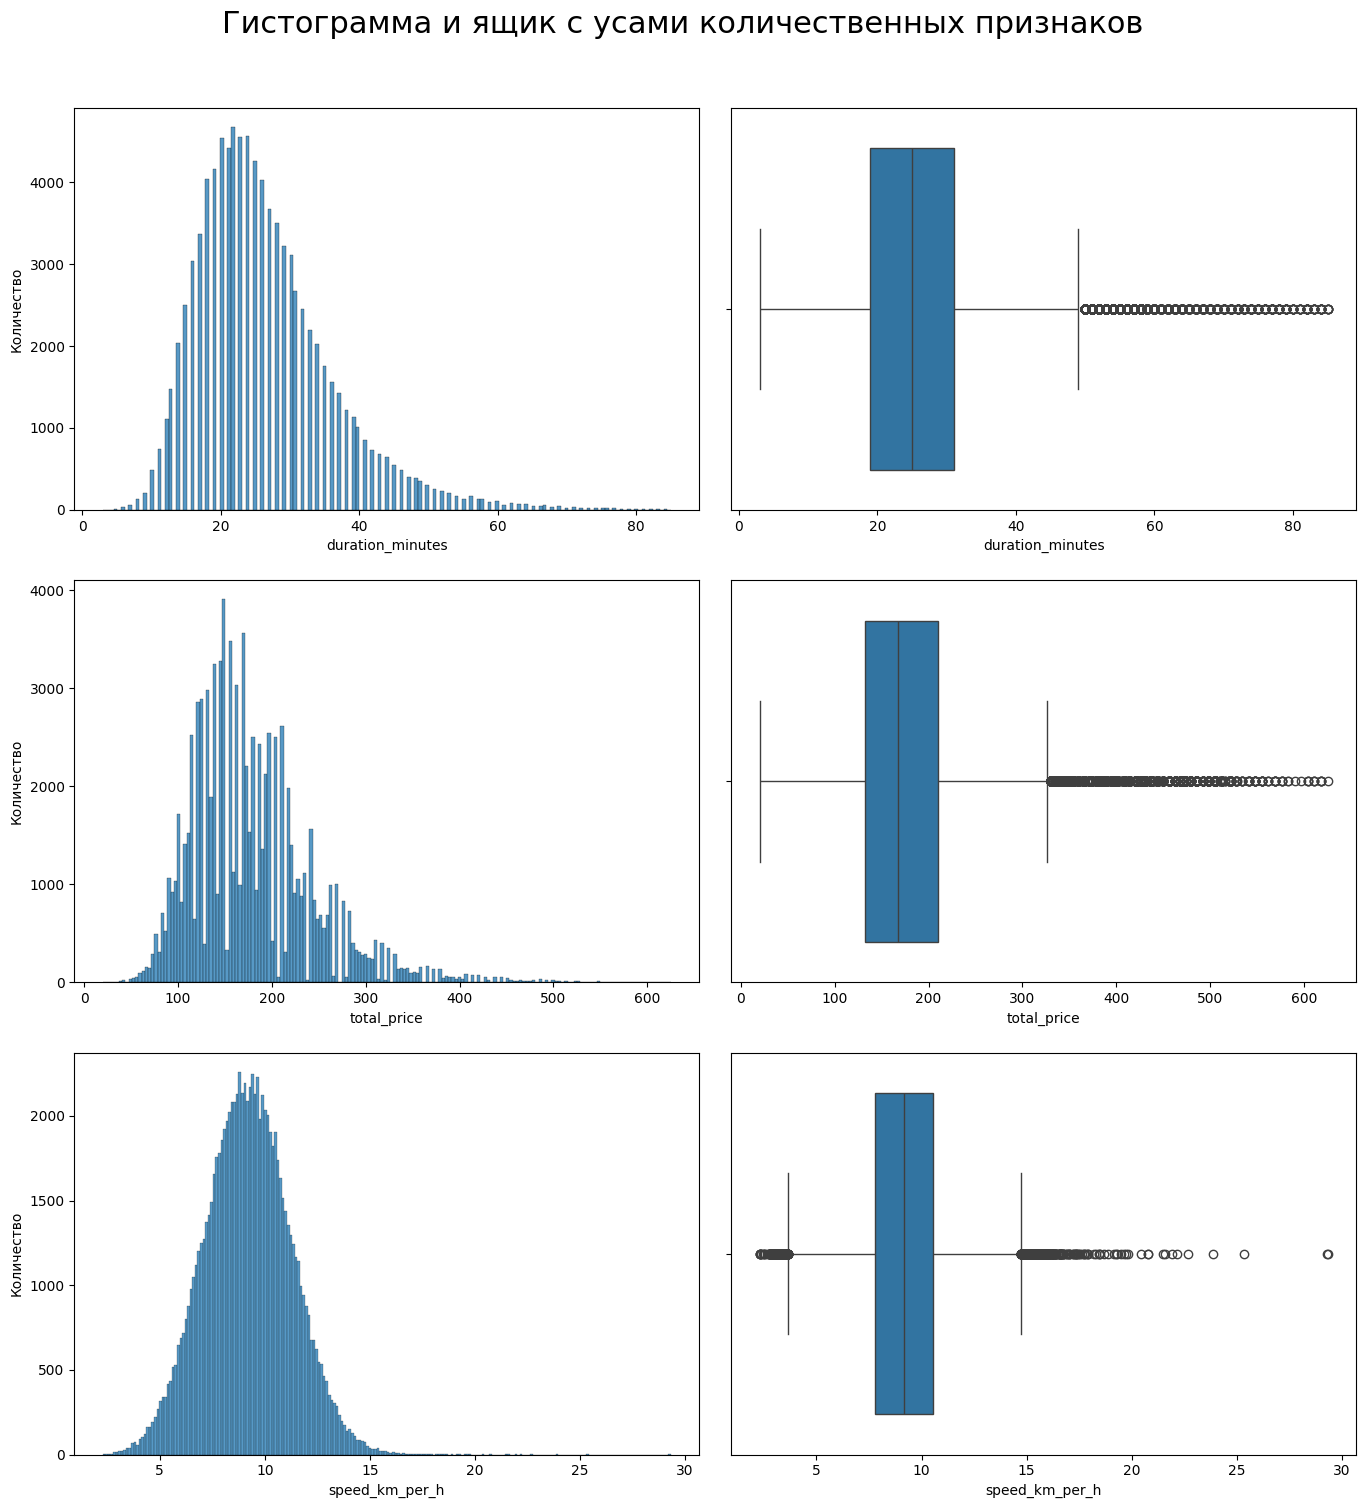

In [17]:
plot_hist_boxplot(rides_data, ["duration_minutes", "total_price", "speed_km_per_h"])

**Вывод:**

Все три признака имеют корректные диапазоны значений и реалистичные распределения. Аномалий, технических выбросов или ошибочных записей не выявлено — дополнительная очистка для данного блока не требуется.

### 4.7. Преобразование типов

Колонка `promo` содержит бинарные значения (1 — акция использована, 0 — нет).
Преобразуем её в категориальный признак и заменяем значения на "Да" / "Нет" для удобства анализа и визуализации.

In [18]:
rides_data["promo"] = rides_data["promo"].apply(lambda val: "Да" if val == 1 else "Нет")

Преобразуем числовые значения дня недели (0–6) в читаемые названия на русском языке с помощью функции normalize_day_of_week.
Колонка становится категориальной для удобства анализа и визуализации.

In [19]:
rides_data["day_of_week"] = rides_data["day_of_week"].apply(normalize_day_of_week)

Создаем признак day_of_week_type на основе нормализованного фактора day_of_week

In [20]:
rides_data["day_of_week_type"] = rides_data["day_of_week"].apply(
    lambda day: "выходной" if day in ["суббота", "воскресенье"] else "будний"
)

## 5. Очистка данных о погоде

### 5.1. Удаление ненужных столбцов

Удаляется колонка wind_gust, поскольку она дублирует информацию о порывах ветра.

In [21]:
weather_data = weather_data.drop("wind_gust", axis=1)

### 5.2. Удаление дубликатов

In [22]:
weather_data = weather_data.drop_duplicates()

weather_data.duplicated().sum()

np.int64(0)

### 5.3. Удаление первой служебной строки

Первая строка содержит единицы измерения (°C, km/h, mm и т.п.), которые не нужны для анализа, поэтому её удаляем.

In [23]:
weather_data = weather_data.iloc[1:].reset_index(drop=True)

### 5.4. Преобразование текстовых колонок в числовые

* Столбцы с типом object могут содержать текстовые значения.
* Используем pd.to_numeric(errors="coerce"), чтобы некорректные значения превратить в NaN.
* Это важно для дальнейшей интерполяции и работы с временным рядом.

In [24]:
cat_cols = weather_data.select_dtypes(include=[object]).columns
for cat in cat_cols:
    weather_data[cat] = pd.to_numeric(weather_data[cat], errors="coerce")

### 5.5. Создание новых признаков

Добавляем признак `month`.

In [25]:
weather_data["month"] = weather_data["datetime"].dt.month

col = weather_data.pop('month')
weather_data.insert(1, 'month', col)

Добавляем признак `hour`.

In [26]:
weather_data['hour'] = weather_data['datetime'].dt.hour

col = weather_data.pop('hour')
weather_data.insert(2, 'hour', col)

### 5.6. Заполнение пропусков в погодных признаках

In [27]:
# Заполняем медианой
weather_data = fill_na_median_by_group(
    weather_data, ['precipitation_total', 'temperature', 'sunshine_duration'], ['month', 'hour']
)

# Интерполируем оставшиеся признаки
weather_data = interpolate_time(
    weather_data, ['wind_speed', 'cloud_cover_total']
)

## 6. Объединяем данные о поездках с погодой по часу начала поездки

In [28]:
rides_weather_data = rides_data.merge(
    weather_data,
    left_on='hour_timestamp',
    right_on='datetime',
    how='left'
)

Проверяем, что объединение датасетов прошло корректно

In [29]:
rides_weather_data.sample(5)

,id,start_date,end_date,day_of_week,start_location,start_district,end_location,end_district,distance,promo,...,day_timestamp,day_of_week_type,datetime,month,hour,temperature,precipitation_total,wind_speed,cloud_cover_total,sunshine_duration
10256,111044,2023-05-04 21:49:40,2023-05-04 22:16:42,четверг,победы,юго-восточный,озерная,юго-восточный,4693.0,Нет,...,2023-05-04,будний,2023-05-04 21:00:00,5,21,18.220245,0.0,8.161764,3.0,0.000000
75905,179561,2023-07-14 19:52:35,2023-07-14 20:16:12,пятница,цветочная,северо-западный,чкалова,юго-восточный,4213.0,Нет,...,2023-07-14,будний,2023-07-14 19:00:00,7,19,26.420246,0.0,7.289444,0.0,60.000000
50588,153133,2023-06-18 14:20:48,2023-06-18 14:37:30,воскресенье,космонавтов,юго-восточный,коммунальная,юго-восточный,2791.0,Нет,...,2023-06-18,выходной,2023-06-18 14:00:00,6,14,31.270245,0.0,1.297998,67.0,19.393942
54778,157509,2023-06-23 15:13:43,2023-06-23 15:36:57,пятница,труда,центральный,сосновая,юго-восточный,3931.0,Нет,...,2023-06-23,будний,2023-06-23 15:00:00,6,15,25.960245,0.0,10.245780,64.0,21.212122
40312,142424,2023-06-07 23:04:19,2023-06-07 23:25:56,среда,советская,центральный,совхозная,центральный,3648.0,Нет,...,2023-06-07,будний,2023-06-07 23:00:00,6,23,15.450245,0.0,4.334974,17.0,0.000000


## 7. Сохраняем очищенные файлы

In [30]:
rides_data.to_csv(pj("data", "cleaned_rides.csv"), index=False)
weather_data.to_csv(pj("data", "cleaned_weather.csv"), index=False)
rides_weather_data.to_csv(pj("data", "rides_weather_data.csv"), index=False)

## Итоговый вывод по предобработке данных

В результате предобработки данных о поездках и погоде получены чистые и готовые к анализу наборы данных. Основные выводы:

### 1. Данные о поездках
- Дубликаты полностью удалены, структура датасета однородная.
- Пропуски в ключевых числовых признаках (например, `distance`) заполнены медианой по маршрутам; оставшиеся пропуски удалены.
- Экстремальные значения в `distance` удалены с помощью метода IQR.
- Созданы новые признаки:
  - `duration_minutes` — длительность поездки в минутах
  - `total_price` — итоговая стоимость поездки
  - `speed_km_per_h` — средняя скорость
  - `day_of_week`, `day_of_week_type` — день недели и тип дня (будний/выходной)
  - `hour_timestamp`, `day_timestamp` — временные признаки для анализа
- Все новые признаки имеют реалистичные диапазоны и корректные распределения.
- Признак `promo` преобразован в категориальный с удобными значениями ("Да"/"Нет").

### 2. Данные о погоде
- Удалены дублирующие и служебные столбцы (`wind_gust`, первая строка с единицами измерения).
- Пропуски заполнены медианой с учетом месяца и часа; оставшиеся признаки интерполированы во временном ряду.
- Созданы временные признаки `month` и `hour`.
- Типы данных приведены к числовым для корректной работы с временными рядами.

### 3. Объединение данных
- Данные о поездках успешно объединены с погодой по часу начала поездки (`hour_timestamp` → `datetime`).
- Итоговый датасет `rides_weather_data` содержит как характеристики поездок, так и погодные условия для дальнейшего анализа.

**Вывод:**

Датасеты `cleaned_rides.csv`, `cleaned_weather.csv` и `rides_weather_data.csv` полностью подготовлены и могут быть использованы для построения аналитических моделей, визуализации и проверки гипотез. Данные очищены от пропусков, дубликатов и экстремальных значений, а все ключевые признаки имеют корректные форматы и распределения.